In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)
import random 
random.seed(31337)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 

dataset_fname = 'bursi.pos.gspan'

In [18]:
%%time
# induce a grammar and train an estimator
training_graphs = get_graphs(dataset_fname, size=250)

from graphlearn.graphlearn import GraphLearnSampler
from eden.graph import Vectorizer
sampler=GraphLearnSampler(radius_list=[0,1], thickness_list=[1],
                          min_cip_count=2, min_interface_count=2,
                          vectorizer=Vectorizer(5))
#take nu% of data as outlier
sampler.fit(training_graphs,
            nu=0.2, 
            n_jobs=-1)

print('graph grammar stats:')
interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (interface_counts, core_counts, cip_counts))


Classifier:
SGDClassifier(alpha=0.000508571187981, average=False, class_weight=None,
       epsilon=0.1, eta0=0.363356184075, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=14, n_jobs=1,
       penalty='l1', power_t=0.268459545247, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
#interfaces: 77   #cores: 80   #core-interface-pairs: 399
graph grammar stats:
#interfaces: 77   #cores: 80   #core-interface-pairs: 399
CPU times: user 19.6 s, sys: 1.28 s, total: 20.9 s
Wall time: 35.1 s


In [19]:
%%time
# graph sampling
graphs = get_graphs(dataset_fname, size=100)
id_start=60
id_end=id_start+9
from itertools import islice
graphs = islice(graphs,id_start,id_end)

# sample
from graphlearn.graphlearn import GraphLearnSampler
graphs = sampler.sample(graphs,
                        n_steps=40, n_samples=6,
                        probabilistic_core_choice=False,
                        max_core_size_diff=1,
                        improving_threshold=0.5, accept_static_penalty=0,
                        n_jobs=1,burnin=0,select_cip_max_tries=400,keep_duplicates=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 44.1 µs


preprocessing grammar
_sample_notes: None
accept_static_penalty: 0
batch_size: 10
    burnin: 0
complexity: 3
 estimator: CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000508571187981, average=False, class_weight=None,
       epsilon=0.1, eta0=0.363356184075, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=14, n_jobs=1,
       penalty='l1', power_t=0.268459545247, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=2, method='sigmoid')
estimatorobject: <graphlearn.estimator.estimator instance at 0x7f4a9d0b06c8>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7f4acfcdbfc8>
generator_mode: False
hash_bitmask: 1048575
improving_threshold: 0.5
keep_duplicates: True
      lsgg: <graphlearn.localsubstitutablegraphgrammar.LocalSubstitutableGraphGrammar object at 0x7f4a9dc4cc10>
max_core_size_diff: 1
    n_jobs: 1
   n_steps: 40
      nbit: 20
node_entity_check: <function <lambda

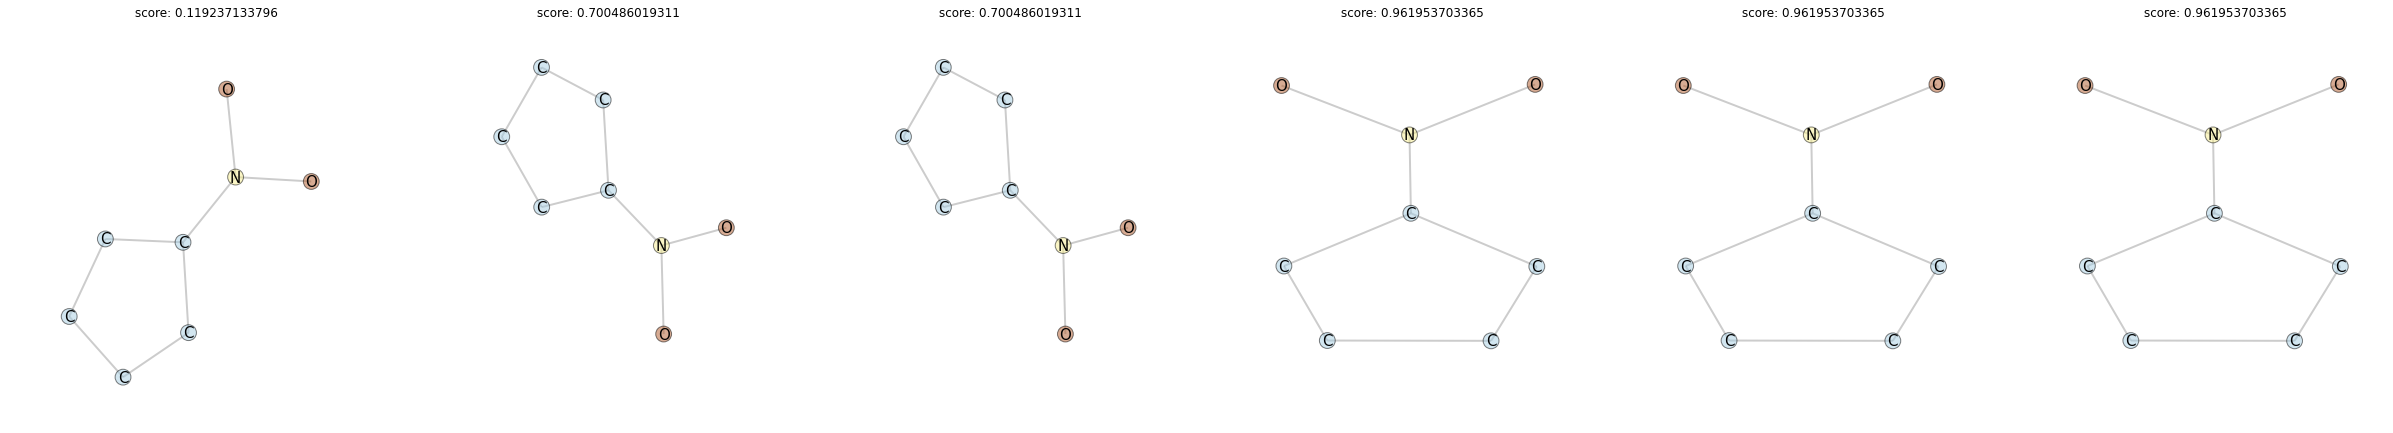

iteration:0
Working with 6 cores
Working with 6 cores
Working with 25 cores
iteration:1
Working with 2 cores
iteration:2
Working with 8 cores
iteration:3
Working with 3 cores
iteration:4
Working with 6 cores
Working with 2 cores
Working with 17 cores
Working with 25 cores
Working with 3 cores
Working with 6 cores
iteration:5
Working with 6 cores
Working with 2 cores
Working with 2 cores
iteration:6
Working with 6 cores
iteration:7
Working with 26 cores
iteration:8
Working with 13 cores
Working with 1 cores
Working with 17 cores
iteration:9
Working with 17 cores
Working with 9 cores
iteration:10
Working with 1 cores
Working with 25 cores
Working with 6 cores
iteration:11
Working with 8 cores
iteration:12
Working with 7 cores
iteration:13
Working with 5 cores
Working with 3 cores
Working with 4 cores
iteration:14
Working with 28 cores
Working with 17 cores
Working with 11 cores
Working with 14 cores
iteration:15
Working with 25 cores
iteration:16
Working with 6 cores
Working with 7 cores

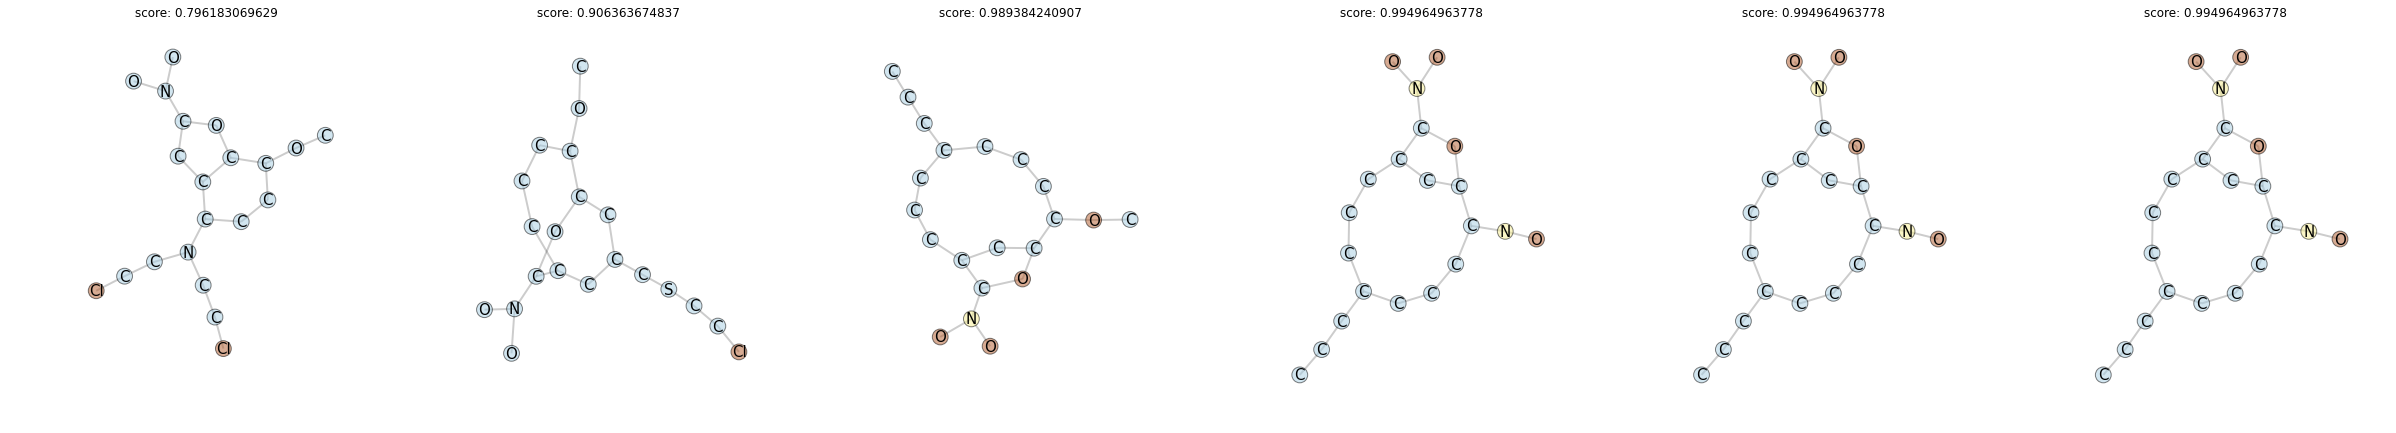

iteration:0
Working with 28 cores
Working with 6 cores
Working with 6 cores
Working with 28 cores
iteration:1
Working with 2 cores
iteration:2
Working with 6 cores
iteration:3
Working with 28 cores
Working with 28 cores
Working with 17 cores
iteration:4
Working with 6 cores
iteration:5
Working with 17 cores
Working with 28 cores
Working with 9 cores
Working with 28 cores
Working with 6 cores
iteration:6
Working with 12 cores
iteration:7
Working with 12 cores
iteration:8
Working with 6 cores
iteration:9
Working with 28 cores
Working with 12 cores
Working with 28 cores
Working with 28 cores
Working with 5 cores
Working with 12 cores
iteration:10
Working with 12 cores
Working with 12 cores
iteration:11
Working with 28 cores
Working with 17 cores
Working with 4 cores
iteration:12
Working with 28 cores
Working with 12 cores
Working with 28 cores
Working with 12 cores
Working with 28 cores
Working with 9 cores
Working with 3 cores
Working with 28 cores
Working with 25 cores
Working with 5 co

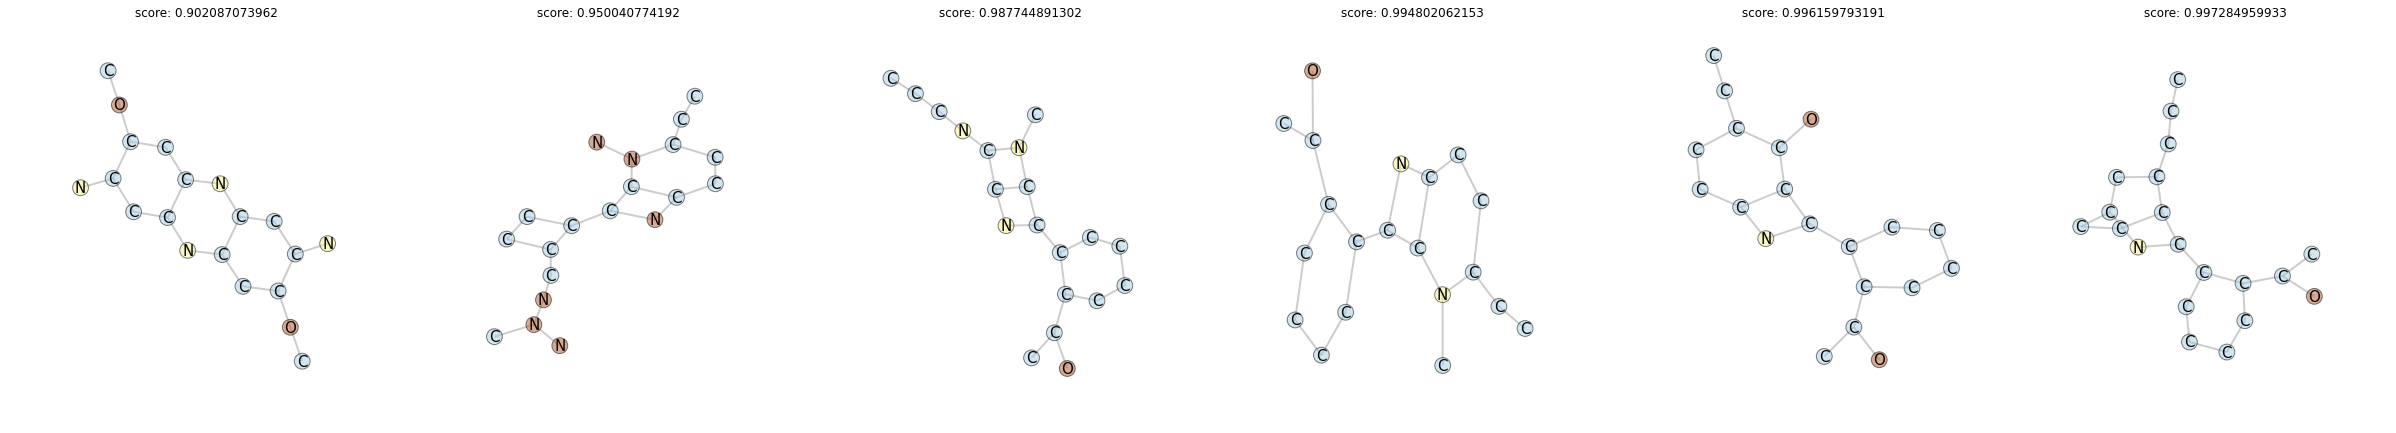

iteration:0
Working with 6 cores
iteration:1
Working with 10 cores
iteration:2
Working with 17 cores
iteration:3
Working with 12 cores
iteration:4
Working with 25 cores
iteration:5
Working with 11 cores
Working with 28 cores
Working with 17 cores
Working with 17 cores
Working with 28 cores
Working with 17 cores
Working with 3 cores
iteration:6
Working with 2 cores
Working with 11 cores
Working with 28 cores
Working with 28 cores
Working with 28 cores
Working with 17 cores
Working with 17 cores
iteration:7
Working with 17 cores
Working with 2 cores
Working with 3 cores
Working with 6 cores
iteration:8
Working with 4 cores
Working with 17 cores
iteration:9
Working with 25 cores
Working with 1 cores
iteration:10
Working with 25 cores
Working with 7 cores
Working with 17 cores
iteration:11
Working with 1 cores
iteration:12
Working with 28 cores
Working with 25 cores
Working with 1 cores
iteration:13
Working with 28 cores
Working with 3 cores
Working with 28 cores
Working with 12 cores
Work

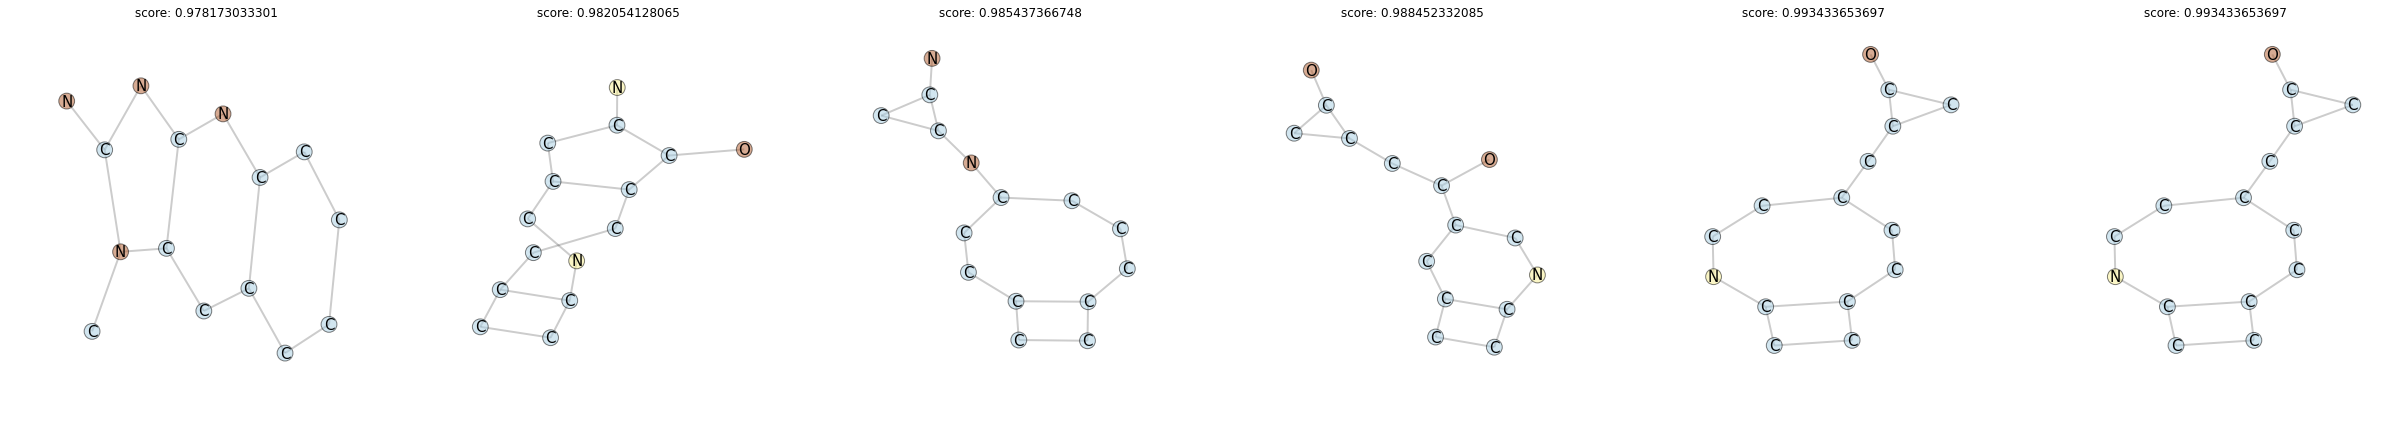

iteration:0
Working with 10 cores
Working with 6 cores
iteration:1
Working with 17 cores
iteration:2
Working with 28 cores
Working with 12 cores
Working with 28 cores
Working with 28 cores
Working with 10 cores
Working with 25 cores
iteration:3
Working with 17 cores
iteration:4
Working with 1 cores
iteration:5
Working with 2 cores
iteration:6
Working with 9 cores
iteration:7
Working with 17 cores
Working with 8 cores
iteration:8
Working with 4 cores
iteration:9
Working with 17 cores
Working with 4 cores
iteration:10
Working with 1 cores
iteration:11
Working with 28 cores
Working with 12 cores
Working with 2 cores
iteration:12
Working with 9 cores
iteration:13
Working with 1 cores
iteration:14
Working with 25 cores
Working with 12 cores
Working with 17 cores
Working with 9 cores
iteration:15
Working with 28 cores
Working with 4 cores
iteration:16
Working with 4 cores
iteration:17
Working with 8 cores
iteration:18
Working with 4 cores
iteration:19
Working with 9 cores
iteration:20
Workin

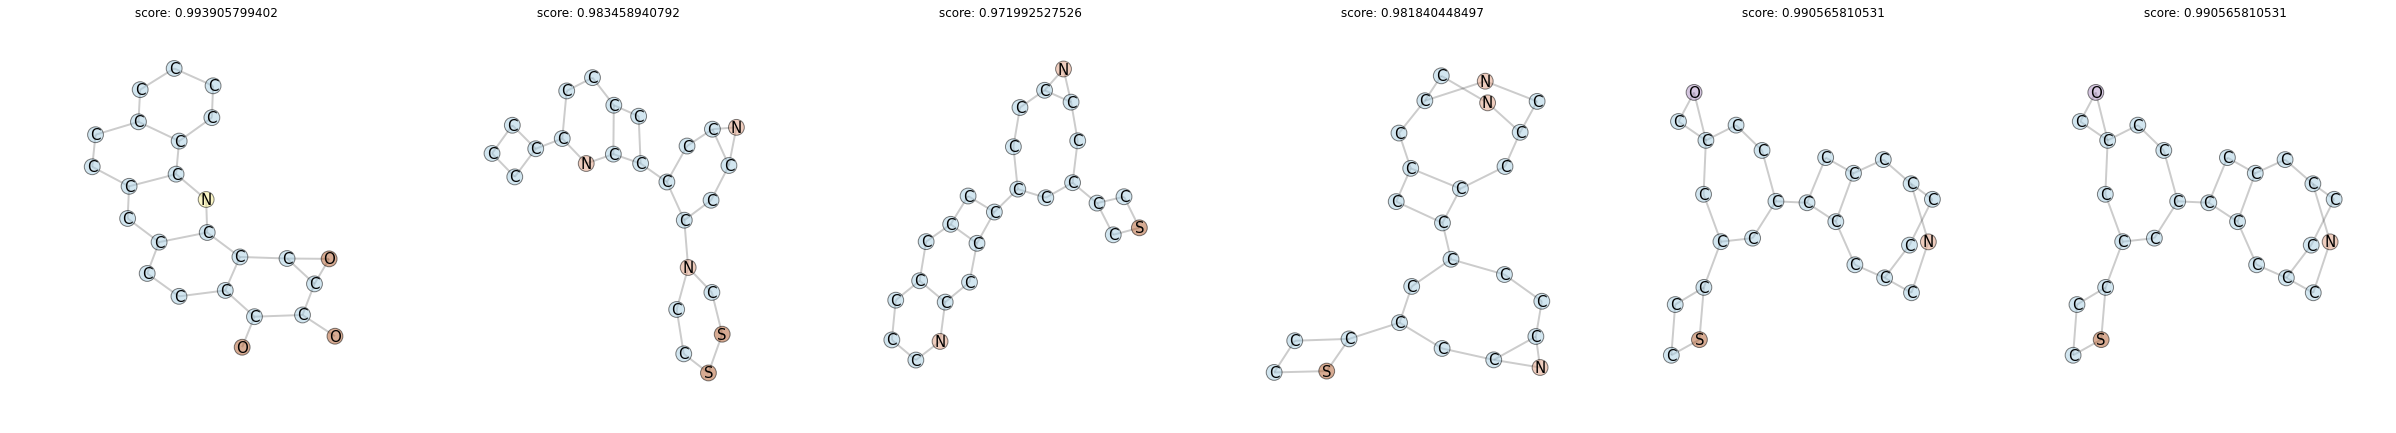

iteration:0
Working with 28 cores
Working with 28 cores
Working with 3 cores
Working with 9 cores
iteration:1
Working with 25 cores
Working with 17 cores
Working with 25 cores
Working with 17 cores
Working with 28 cores
Working with 1 cores
iteration:2
Working with 28 cores
Working with 12 cores
Working with 8 cores
iteration:3
Working with 3 cores
iteration:4
Working with 25 cores
Working with 3 cores
Working with 28 cores
iteration:5
Working with 3 cores
Working with 28 cores
Working with 3 cores
Working with 28 cores
iteration:6
Working with 3 cores
Working with 17 cores
Working with 28 cores
Working with 3 cores
Working with 17 cores
Working with 25 cores
iteration:7
Working with 28 cores
Working with 25 cores
Working with 3 cores
iteration:8
Working with 12 cores
Working with 8 cores
iteration:9
Working with 5 cores
Working with 12 cores
Working with 18 cores
iteration:10
Working with 28 cores
Working with 18 cores
iteration:11
Working with 2 cores
iteration:12
Working with 17 cor

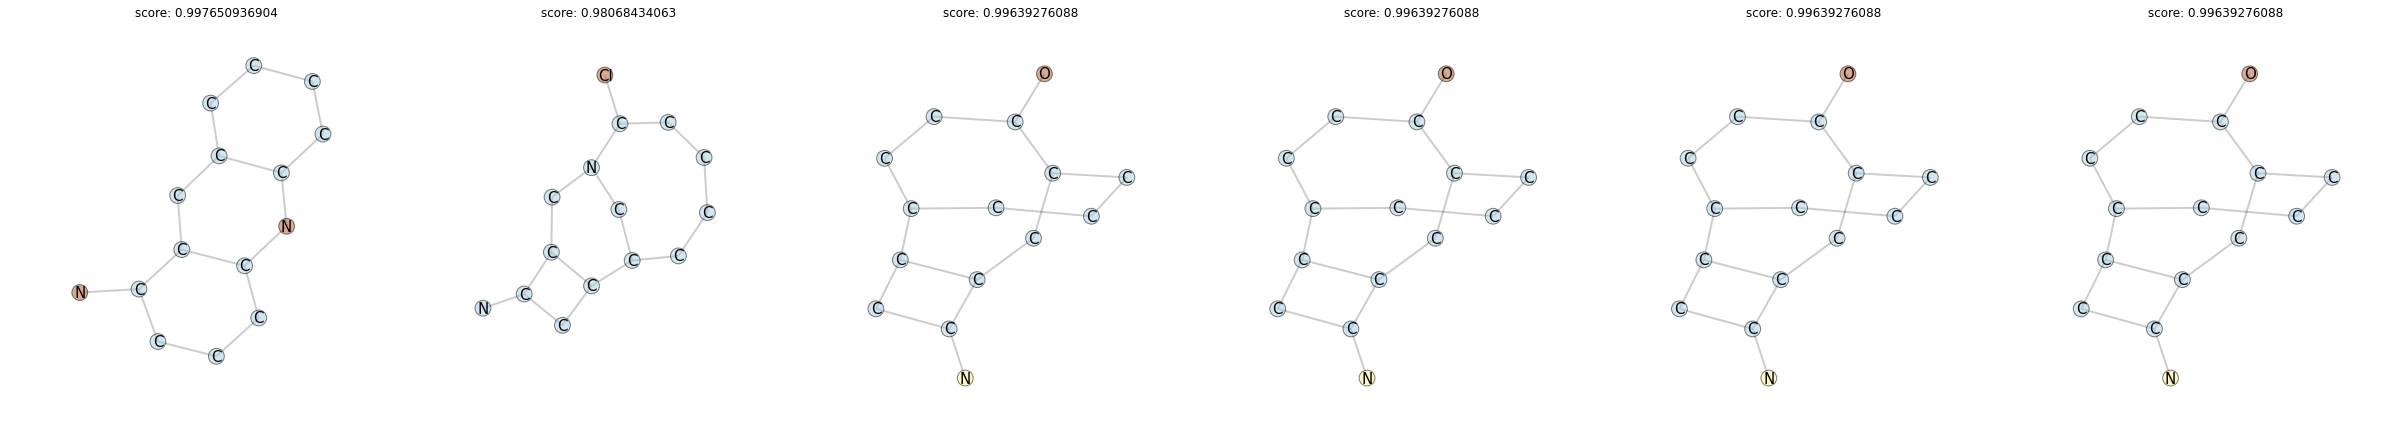

iteration:0
Working with 28 cores
Working with 17 cores
iteration:1
Working with 6 cores
iteration:2
Working with 2 cores
iteration:3
Working with 17 cores
iteration:4
Working with 2 cores
iteration:5
Working with 5 cores
Working with 28 cores
Working with 3 cores
Working with 17 cores
iteration:6
Working with 29 cores
iteration:7
Working with 4 cores
iteration:8
Working with 28 cores
Working with 17 cores
iteration:9
Working with 17 cores
iteration:10
Working with 29 cores
iteration:11
Working with 11 cores
Working with 17 cores
iteration:12
Working with 6 cores
Working with 28 cores
Working with 1 cores
iteration:13
Working with 9 cores
iteration:14
Working with 28 cores
Working with 2 cores
iteration:15
Working with 17 cores
Working with 28 cores
Working with 28 cores
Working with 6 cores
Working with 28 cores
Working with 28 cores
Working with 28 cores
Working with 6 cores
Working with 1 cores
iteration:16
Working with 17 cores
Working with 17 cores
Working with 28 cores
Working wi

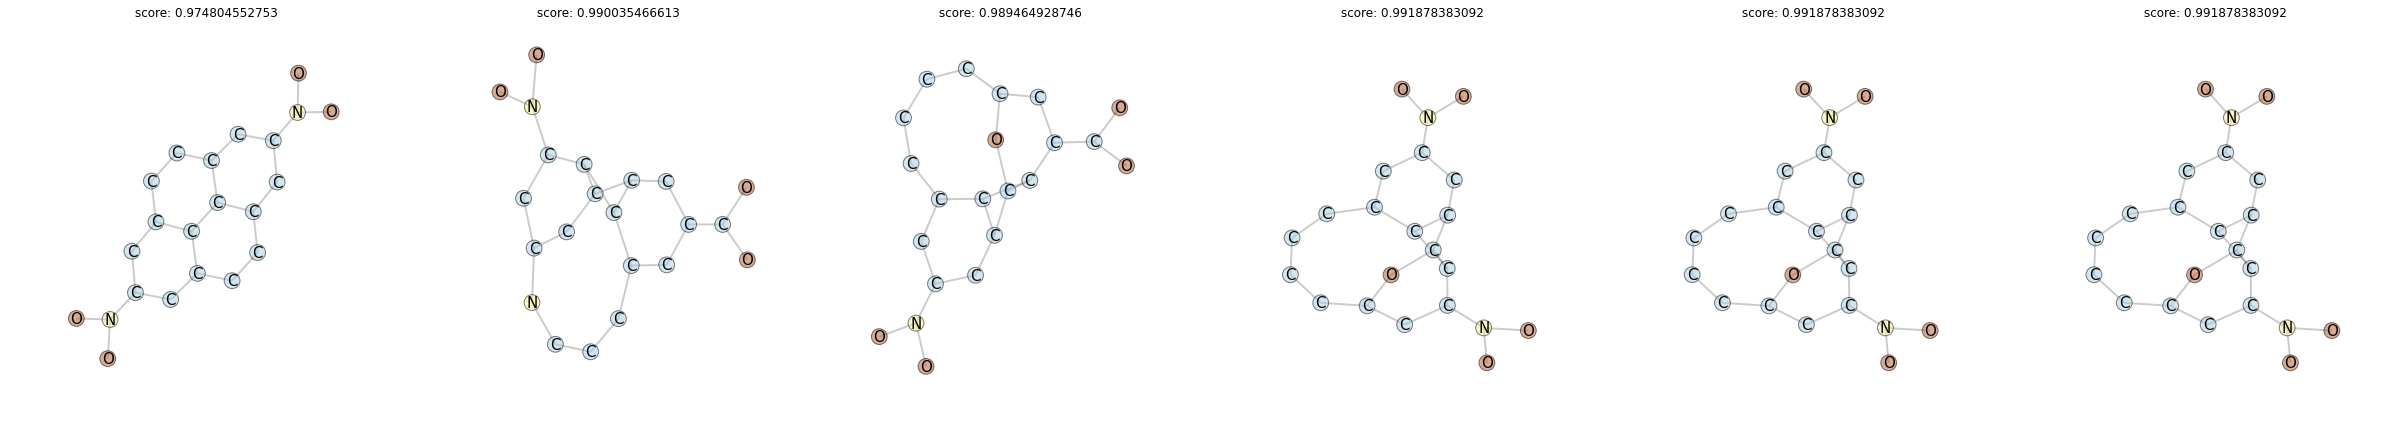

iteration:0
Working with 28 cores
Working with 28 cores
Working with 1 cores
iteration:1
Working with 28 cores
Working with 28 cores
Working with 3 cores
Working with 28 cores
Working with 17 cores
iteration:2
Working with 12 cores
Working with 28 cores
Working with 28 cores
iteration:3
Working with 2 cores
iteration:4
Working with 1 cores
Working with 12 cores
Working with 4 cores
iteration:5
Working with 3 cores
Working with 4 cores
iteration:6
Working with 28 cores
Working with 8 cores
iteration:7
Working with 28 cores
Working with 17 cores
Working with 28 cores
Working with 25 cores
Working with 17 cores
iteration:8
Working with 8 cores
iteration:9
Working with 28 cores
Working with 8 cores
iteration:10
Working with 3 cores
Working with 25 cores
Working with 3 cores
Working with 2 cores
iteration:11
Working with 28 cores
Working with 17 cores
Working with 3 cores
Working with 2 cores
iteration:12
Working with 2 cores
iteration:13
Working with 13 cores
iteration:14
Working with 9 co

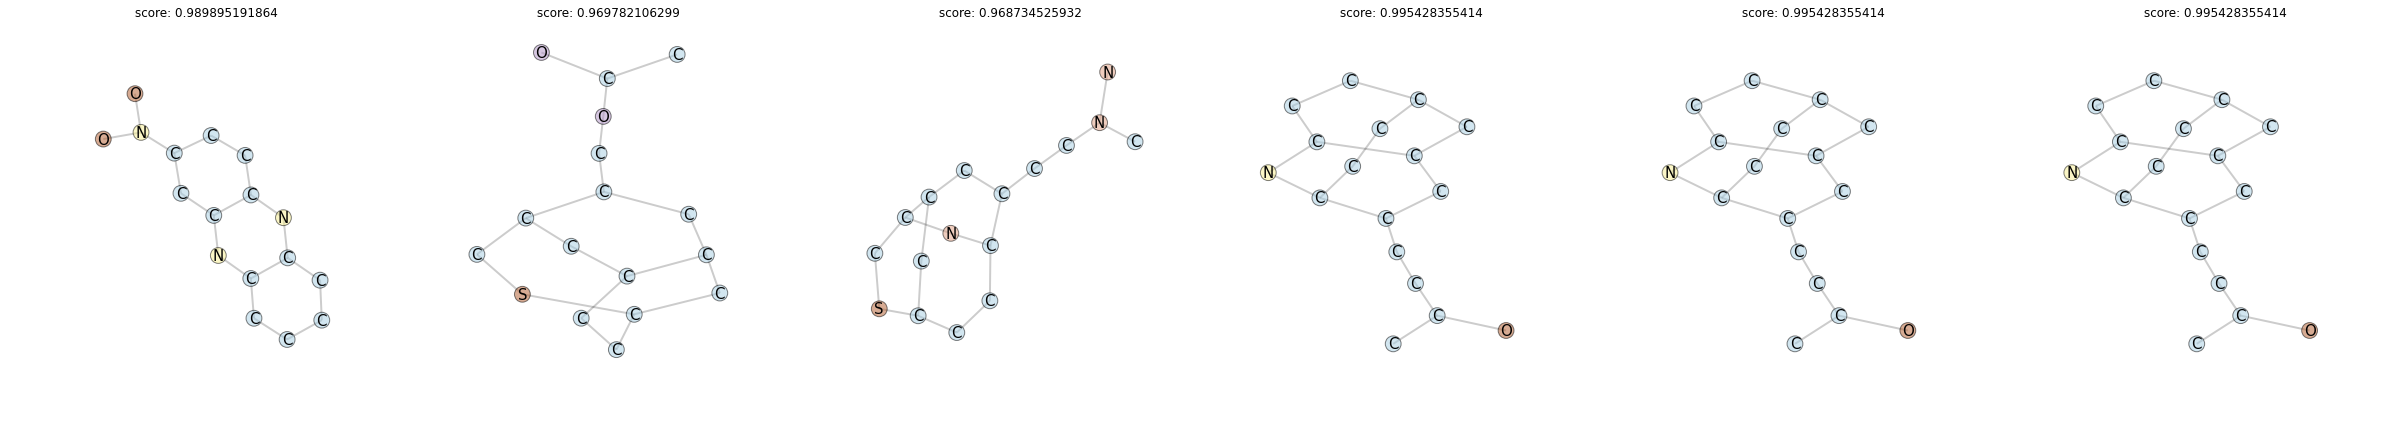

iteration:0
Working with 9 cores
Working with 6 cores
Working with 28 cores
Working with 28 cores
Working with 28 cores
Working with 6 cores
iteration:1
Working with 8 cores
iteration:2
Working with 9 cores
Working with 8 cores
iteration:3
Working with 28 cores
Working with 25 cores
Working with 9 cores
Working with 28 cores
iteration:4
Working with 7 cores
Working with 3 cores
iteration:5
Working with 25 cores
iteration:6
Working with 2 cores
Working with 25 cores
iteration:7
Working with 25 cores
iteration:8
Working with 17 cores
Working with 13 cores
Working with 1 cores
Working with 7 cores
Working with 7 cores
Working with 2 cores
Working with 28 cores
Working with 6 cores
iteration:9
Working with 13 cores
Working with 17 cores
Working with 5 cores
Working with 2 cores
Working with 25 cores
Working with 29 cores
Working with 17 cores
Working with 4 cores
iteration:10
Working with 1 cores
Working with 11 cores
iteration:11
Working with 17 cores
Working with 17 cores
Working with 7 

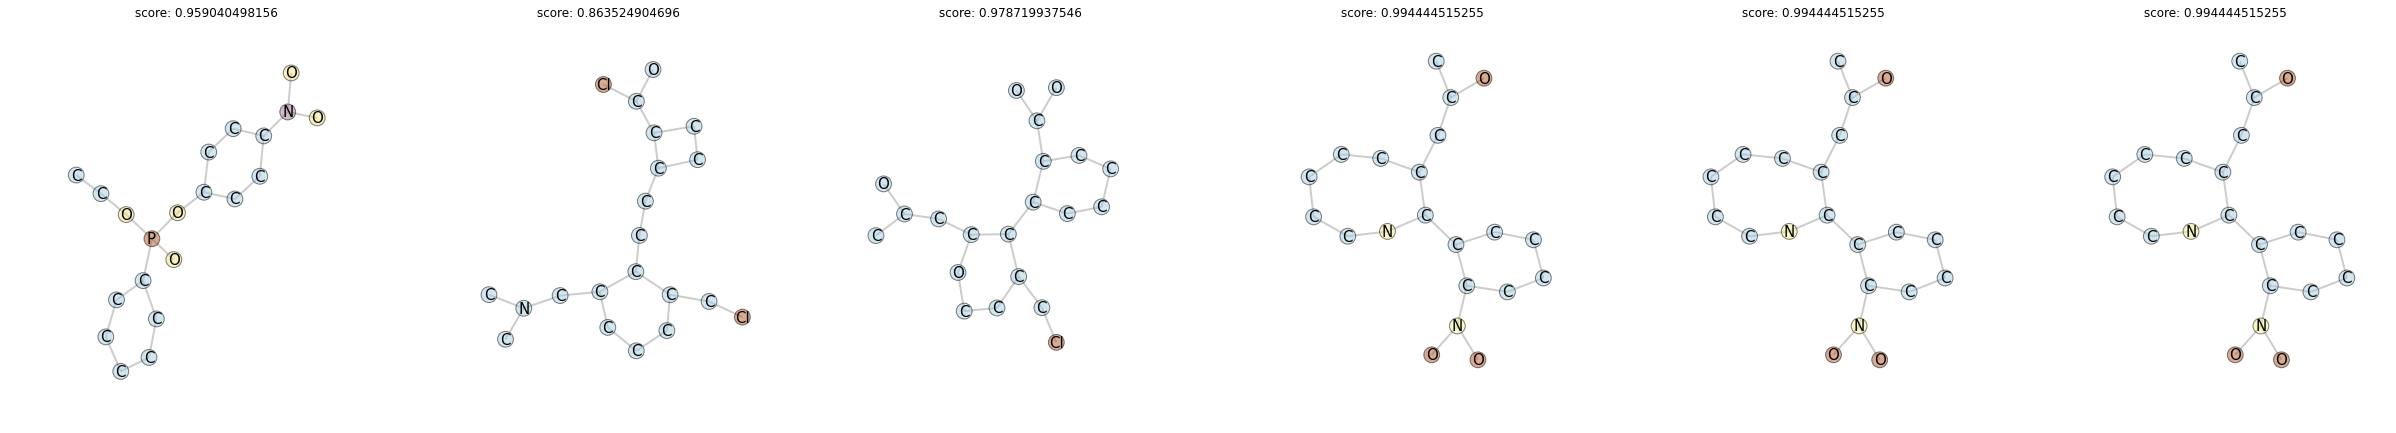

CPU times: user 33.8 s, sys: 1.34 s, total: 35.2 s
Wall time: 37.2 s


In [20]:
%%time
# plot examples of sampling paths
from graphlearn.utils.draw import  graphlearn_draw, get_score_of_graph
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    graphlearn_draw(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=250,
                   headlinehook=get_score_of_graph)

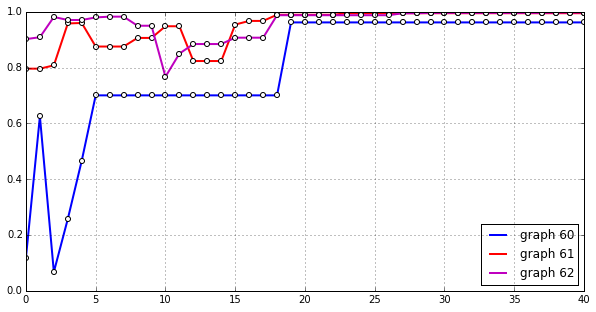

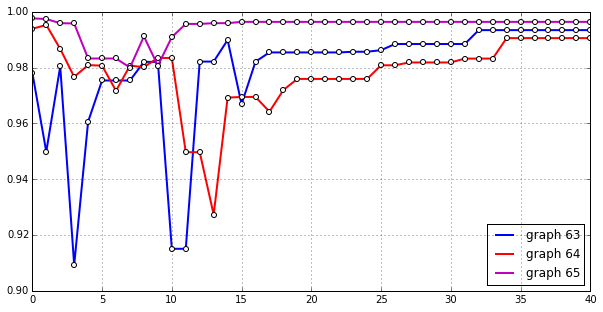

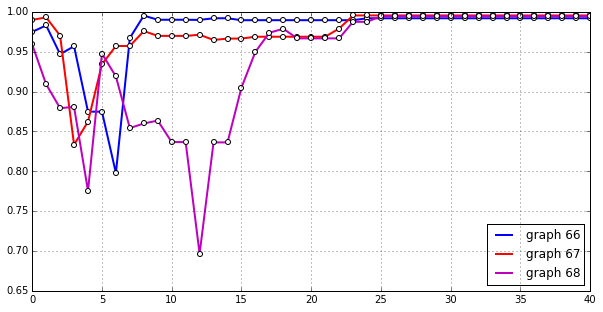

CPU times: user 788 ms, sys: 32 ms, total: 820 ms
Wall time: 820 ms


In [21]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None', markerfacecolor='white', marker='o', markeredgewidth=1,markersize=5)
    plt.legend(loc='lower right')
    plt.grid()
    #plt.ylim(-0.1,1.1)
    plt.show()

.